In [2]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
from pathlib import Path

In [3]:
data_root = Path('../data/BRCA1')

# sample name
sample_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'
adata = sc.read_visium(data_root / sample_name)
print(adata)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / 'metadata.tsv', sep='\t')
# 确保元数据中的索引与 adata.obs 中的索引匹配
df_meta.set_index('ID', inplace=True)
adata.obs.index = adata.obs.index.astype(str)
df_meta.index = df_meta.index.astype(str)
adata.obs['fine_annot_type'] = df_meta['fine_annot_type']
n_clusters = len(adata.obs['fine_annot_type'].unique())

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 52.48it/s]

Optimization finished for ST data!


In [5]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'fine_annot_type'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [6]:
tool = 'leiden' # mclust, leiden, and louvain
radius = 50
# clustering
from GraphST.utils import clustering
clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

Searching resolution...


/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resolution=1.989999999999999, cluster number=22
resolution=1.979999999999999, cluster number=21
resolution=1.969999999999999, cluster number=21
resolution=1.959999999999999, cluster number=21
resolution=1.949999999999999, cluster number=21
resolution=1.939999999999999, cluster number=20


In [7]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'fine_annot_type', 'leiden', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'leiden'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'
    obsp: 'distances', 'connectivities'

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


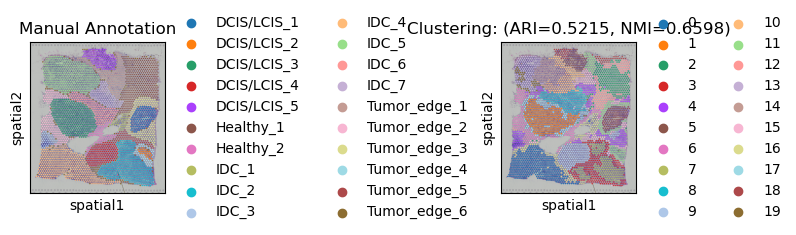

In [8]:
import matplotlib.pyplot as plt
sub_adata = adata[~pd.isnull(adata.obs['fine_annot_type'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['fine_annot_type'], sub_adata.obs['domain'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['fine_annot_type'], sub_adata.obs['domain'])
fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='fine_annot_type', ax=axes[0], show=False)
sc.pl.spatial(adata, color='domain', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.4f, NMI=%.4f)' % (ARI, NMI))
plt.tight_layout()
plt.show()